## School project - 5MLRE
The following notebook was created for a school project to create an anime recommendation system. The subject and the questions are available in the appendix.

The group members who participated in this project are:
- AMIMI Lamine
- BEZIN Théo
- LECOMTE Alexis
- PAWLOWSKI Maxence

### Main index
1. **Data analysis (you are here)**
2. Collaborative filtering
3. Content-based filtering
4. _Appendix_

# 1 - Data analysis
The purpose of this first notebook will be to analyze the data and draw graphs to better understand the dataset before going further.

### Index
<ol type="A">
  <li>The dataset</li>
  <li>Notebook initialization</li>
  <li>Data pre-processing</li>
  <li>Data exploration</li>
  <li>Conclusion of the data analysis</li>
</ol>

## A - The dataset
This project will use a dataset extracted from the [MyAnimeList](https://myanimelist.net/) website. The dataset is actually composed of two datasets which we will explain below.

### A.1 - The anime dataset
This first dataset contains 12,294 animes with the following data:
- **anime_id:** The [MyAnimeList](https://myanimelist.net/) unique identifier.
- **name:** The full name of the anime.
- **genre:** A comma-separated list of the genres of this anime.
- **type:** The type of media of the anime (movie, TV, OVA, ...).
- **episodes:** How many episodes this anime has. It is set at `1` if the anime type is `movie`.
- **rating:** The average rating out of ten for this anime.
- **members:** Number of community members that are in this anime's group.

### A.2 - The rating dataset
The second dataset is the list of user ratings made for the anime in the previous dataset.
- **user_id :** A randomly generated non-identifiable identifier.
- **anime_id:** The [MyAnimeList](https://myanimelist.net/) unique identifier.
- **rating:** The rating out of ten given by this user. If the user watched the anime but did not rate it, the rating is set to `-1`.

## B - Notebook initialization
The following code blocks will be replicated in the next notebooks. Their main purpose is to import the necessary packages, initialize some of them and define a bunch of constants and utility functions used in the project. A small explanation will be added to each block of code, but will then be omitted to avoid repetition.

### B.1 - Imports
Here we import all used packages. This prevents some imports from being hidden in another piece of code and ensures that nothing is imported twice.

In [35]:
# OS and filesystem
from pathlib import Path

# Math
import numpy

# Data
import pandas
from matplotlib import pyplot
import matplotx

# Console output
from colorama import Fore, Style

# Misc.
from ast import literal_eval

### B.2 - Package initialization
We define the style of the graphs generated by the `matplotlib` package to facilitate quick identification of trends and patterns in the data and to effectively communicate the results.

In [36]:
pyplot.rcParams.update(pyplot.rcParamsDefault)
pyplot.style.use(matplotx.styles.dracula)  # Set the matplotlib style

### B.3 - Constants
We also define some constants used in this notebook. If you clone this project, be careful when changing these constants and remember to apply the changes in all notebooks. You may notice that we have defined a random state. Although it is never used for final models, it is useful when we try to compare the performance of different models on the same dataset.

In [37]:
# Filesystem paths
PARENT_FOLDER = Path.cwd()
DATA_FOLDER = (PARENT_FOLDER / ".." / ".." / "data").resolve()
MODELS_FOLDER = (PARENT_FOLDER / ".." / ".." / "models").resolve()
TEMP_FOLDER = (PARENT_FOLDER / ".." / ".." / "temp").resolve()

# Plots
FIG_SIZE = (12, 7)

# Misc.
RANDOM_STATE = 2077

### B.4 - Datasets loading
We then load the two provided datasets. We specify most of the dtypes to save time both in loading and preprocessing the data. You may notice that we set the type of the `episodes` column to `str`. This is because some rows in the dataset contain strings instead of integers. We will deal with this problem later.

In [38]:
data_anime = pandas.read_csv((DATA_FOLDER / "anime.csv"),
                             dtype={"anime_id": int, "name": str, "genre": str, "type": "category", "episodes": str, "rating": float, "members": int})
data_anime

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
...,...,...,...,...,...,...,...
12289,9316,Toushindai My Lover: Minami tai Mecha-Minami,Hentai,OVA,1,4.15,211
12290,5543,Under World,Hentai,OVA,1,4.28,183
12291,5621,Violence Gekiga David no Hoshi,Hentai,OVA,4,4.88,219
12292,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,OVA,1,4.98,175


In [39]:
data_ratings = pandas.read_csv((DATA_FOLDER / "rating.csv"),
                               dtype={"user_id": int, "anime_id": int, "rating": float})
data_ratings

,user_id,anime_id,rating
0,1,20,-1.0
1,1,24,-1.0
2,1,79,-1.0
3,1,226,-1.0
4,1,241,-1.0
...,...,...,...
7813732,73515,16512,7.0
7813733,73515,17187,9.0
7813734,73515,22145,10.0
7813735,73516,790,9.0


## C - Data pre-processing
Before making a more advanced study, we will pre-process the data. We will fill in and/or remove missing values, remove duplicate rows and add a number of utility columns for later use.

### C.1 - Duplicated values
We begin the pre-processing by checking the rate of duplicated data in the dataset.

In [40]:
def duplicated_values(df, df_name: str = None) -> None:
    # Compute the dataset size, the count of duplicated value and the list of duplicated values
    data_count = df.shape[0] * df.shape[1]
    duplicated_count = df.duplicated().sum()
    duplicated = df[df.duplicated(keep=False)] if (duplicated_count > 0) else None

    # Show the result
    df_name = f" ({df_name})" if df_name is not None else ""
    print(f"{Style.BRIGHT}Duplicated values{df_name}:{Style.RESET_ALL} {duplicated_count} ({round((duplicated_count.sum() / data_count) * 100, 2)}%)")
    if duplicated is not None:
        print(duplicated)


duplicated_values(df=data_anime, df_name="Anime")
print()  # Printing a new line
duplicated_values(df=data_ratings, df_name="Ratings")

Duplicated values (Anime): 0 (0.0%)

Duplicated values (Ratings): 1 (0.0%)
         user_id  anime_id  rating
4499258    42653     16498     8.0
4499316    42653     16498     8.0


The `anime` dataset seems to have no duplicated rows, but the `ratings` dataset has two rating with the same `user_id`, `anime_id` and `rating`. It is not much, but it may be a good idea to remove this duplicate.

In [41]:
data_ratings.drop_duplicates(keep="first", inplace=True)

### C.2 - Null and empty values
We then check if the datasets contains any missing data.

In [42]:
def missing_values(df, df_name: str = None, keep_zeros=True) -> None:
    # Compute the dataset size and the count of missing value
    data_count = df.shape[0] * df.shape[1]
    missing = missing_df = df.isna().sum()

    # Filter out column with zero missing value
    if not keep_zeros:
        missing_df = missing_df[missing_df > 0]

    # Calculate the percent of missing values
    missing_df = missing_df.sort_values(ascending=False).apply(lambda m: f"{m} ({round((m * 100) / df.shape[0], 2)}%)")

    # Show the result
    df_name = f" ({df_name})" if df_name is not None else ""
    print((
        f"{Style.BRIGHT}Missing values{df_name}:{Style.RESET_ALL} {round((missing.sum() / data_count) * 100, 2)}%\n"
        f"{Style.DIM}{Fore.WHITE}{missing_df}{Style.RESET_ALL}"
    ))


missing_values(df=data_anime, df_name="Anime", keep_zeros=True)
print()  # Printing a new line
missing_values(df=data_ratings, df_name="Ratings", keep_zeros=True)

Missing values (Anime): 0.37%
rating      230 (1.87%)
genre         62 (0.5%)
type          25 (0.2%)
anime_id       0 (0.0%)
name           0 (0.0%)
episodes       0 (0.0%)
members        0 (0.0%)
dtype: object

Missing values (Ratings): 0.0%
user_id     0 (0.0%)
anime_id    0 (0.0%)
rating      0 (0.0%)
dtype: object


We notice that the `ratings` dataset is perfectly filled, but the `anime` dataset has missing ratings, genres and types. This dataset has also an issue with the `episodes` column containing strings. We can start by filling in the `rating` column using the `ratings` dataset. If at least one rating is found, we calculate the average and add it to the `anime` database. Otherwise, we set the rating to `-1`.

In [43]:
def fill_empty_rating(row: pandas.Series) -> pandas.Series:
    # Fill the rating value if null
    if pandas.isna(row["rating"]):
        ratings_list = data_ratings.index[data_ratings["anime_id"] == row["anime_id"]].tolist()
        row["rating"] = data_ratings.loc[ratings_list]["rating"].mean() if ratings_list else -1

    return row


data_anime = data_anime.apply(fill_empty_rating, axis=1)
data_anime["rating"] = data_anime["rating"].astype(float)

We fill the `gender` column with an `Unknown` string. This will be useful to avoid any problems when later computing this column.

In [44]:
data_anime["genre"] = data_anime["genre"].fillna("Unknown")

We also fill the `type` column with an `Unknown` string. We want to avoid empty values, but we do not want to delete those anime from the recommendation system.

In [45]:
data_anime["type"] = data_anime["type"].fillna("Unknown")

The last correction will be applied to the `episodes` column. Many anime have `Unknown` as the number of episodes while the rest of the dataset has an integer. For the same reason as above, we want to keep as many anime as possible. So we will replace each `Unknown` with `-1`, which will allow us to change the type of the column to integer.

In [46]:
data_anime["episodes"] = data_anime["episodes"].replace(to_replace="Unknown", value=-1, inplace=False).astype(int)

### C.3 - Computation of additional columns
We compute a couple of columns that we will use later. We start by creating a new column containing the split list of genres for each anime.

In [47]:
data_anime.insert(  # Insert the new column right after the "genre" column
    loc=data_anime.columns.get_loc("genre") + 1,
    column="genre_split",
    value=data_anime["genre"].str.split(", ").tolist(),
    allow_duplicates=False
)

Then we add a new column containing the number of ratings received by each anime.

In [48]:
ratings_count_per_anime = data_ratings[data_ratings["rating"] != -1].groupby(["anime_id"]).size().reset_index(name="num_ratings")
data_anime = data_anime.merge(ratings_count_per_anime, how="left", on="anime_id")
data_anime["num_ratings"] = data_anime["num_ratings"].fillna(0).astype(int)

del ratings_count_per_anime

The last step is to calculate the ranking columns. We add a first column based on the average rating of each anime.

In [49]:
data_anime["rank_avg_rating"] = data_anime["rating"].rank(method="average", ascending=False)

And a second one based on the number of ratings received by each anime.

In [50]:
data_anime["rank_num_ratings"] = data_anime["num_ratings"].rank(method="average", ascending=False)

We use the `ascending=False` parameter to assign the lower rank to the highest score. The resulting `anime` dataset looks like this:

In [51]:
data_anime

,anime_id,name,genre,genre_split,type,episodes,rating,members,num_ratings,rank_avg_rating,rank_num_ratings
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural","[Drama, Romance, School, Supernatural]",Movie,1,9.37,200630,1961,4.0,870.5
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...","[Action, Adventure, Drama, Fantasy, Magic, Mil...",TV,64,9.26,793665,21494,6.0,8.0
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...","[Action, Comedy, Historical, Parody, Samurai, ...",TV,51,9.25,114262,1188,7.5,1313.5
3,9253,Steins;Gate,"Sci-Fi, Thriller","[Sci-Fi, Thriller]",TV,24,9.17,673572,17151,9.0,17.0
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...","[Action, Comedy, Historical, Parody, Samurai, ...",TV,51,9.16,151266,3115,10.0,537.0
...,...,...,...,...,...,...,...,...,...,...,...
12289,9316,Toushindai My Lover: Minami tai Mecha-Minami,Hentai,[Hentai],OVA,1,4.15,211,2,11744.0,8847.0
12290,5543,Under World,Hentai,[Hentai],OVA,1,4.28,183,2,11663.0,8847.0
12291,5621,Violence Gekiga David no Hoshi,Hentai,[Hentai],OVA,4,4.88,219,1,11189.5,9513.5
12292,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,[Hentai],OVA,1,4.98,175,1,11087.5,9513.5


### C.4 - Saving the datasets
To preserve the pre-processing and to use our notebooks without having to restart it each time, we save the resulting datasets on the disk. We use a different name so as not to overwrite the original dataset.

In [52]:
data_anime.to_csv((DATA_FOLDER / "anime_cleaned.csv"), index=False, mode="w")
data_ratings.to_csv((DATA_FOLDER / "rating_cleaned.csv"), index=False, mode="w")

Then we can load the datasets like this:

In [53]:
data_anime = pandas.read_csv(DATA_FOLDER / "anime_cleaned.csv", converters={"genre_split": literal_eval})
data_ratings = pandas.read_csv(DATA_FOLDER / "rating_cleaned.csv")

## D - Data exploration
We will now explore both datasets to understand what kind of data we will use in our future recommendation system.

### D.1 - Frequency of anime based on the media type
**To begin with, we would like to know an important information about the popularity of anime broadcasting types.
We use a barchart that is representative and simple enough for this case.**

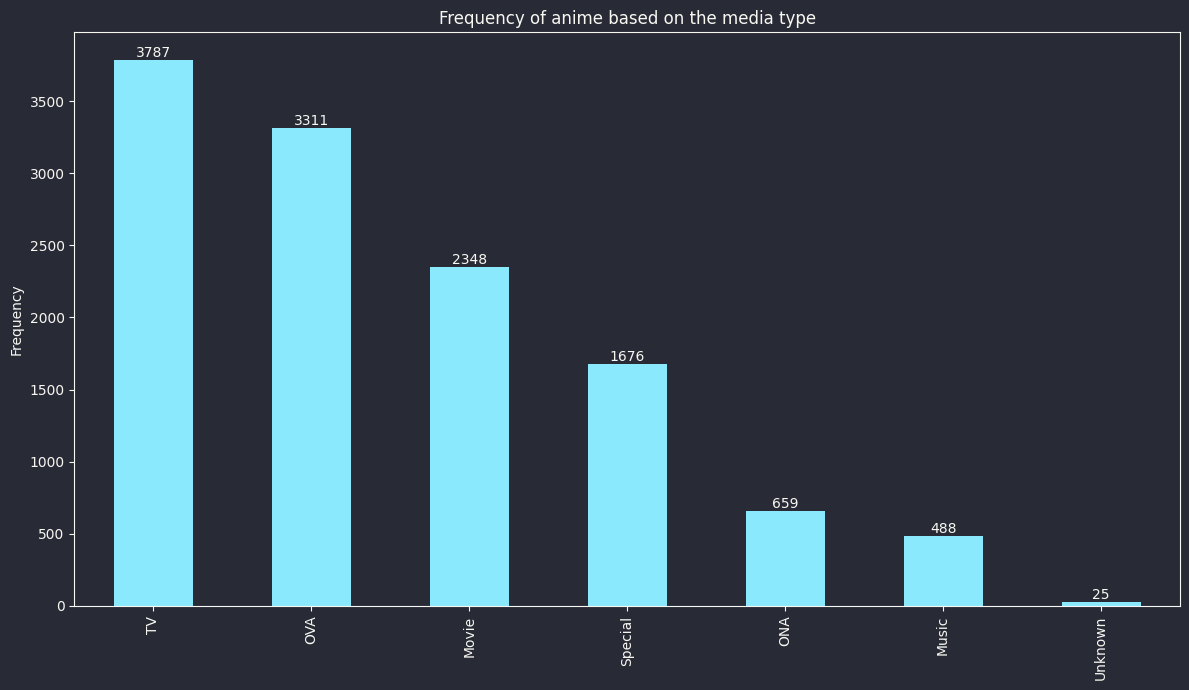

In [54]:
ax = data_anime["type"].value_counts().plot(kind="bar", figsize=FIG_SIZE)
pyplot.title("Frequency of anime based on the media type")
pyplot.ylabel("Frequency")
ax.bar_label(ax.containers[0], label_type="edge")
pyplot.tight_layout()
pyplot.show()

**We note here that most of the animes were broadcasted on television.
Followed by the viewing of OVA (special episodes usually in CD/DVD format).**

### D.2 - Frequency of anime per genre
**It is also interesting to observe which genres are most popular in anime.
For that, we'll use a barchart to show that frequency.**

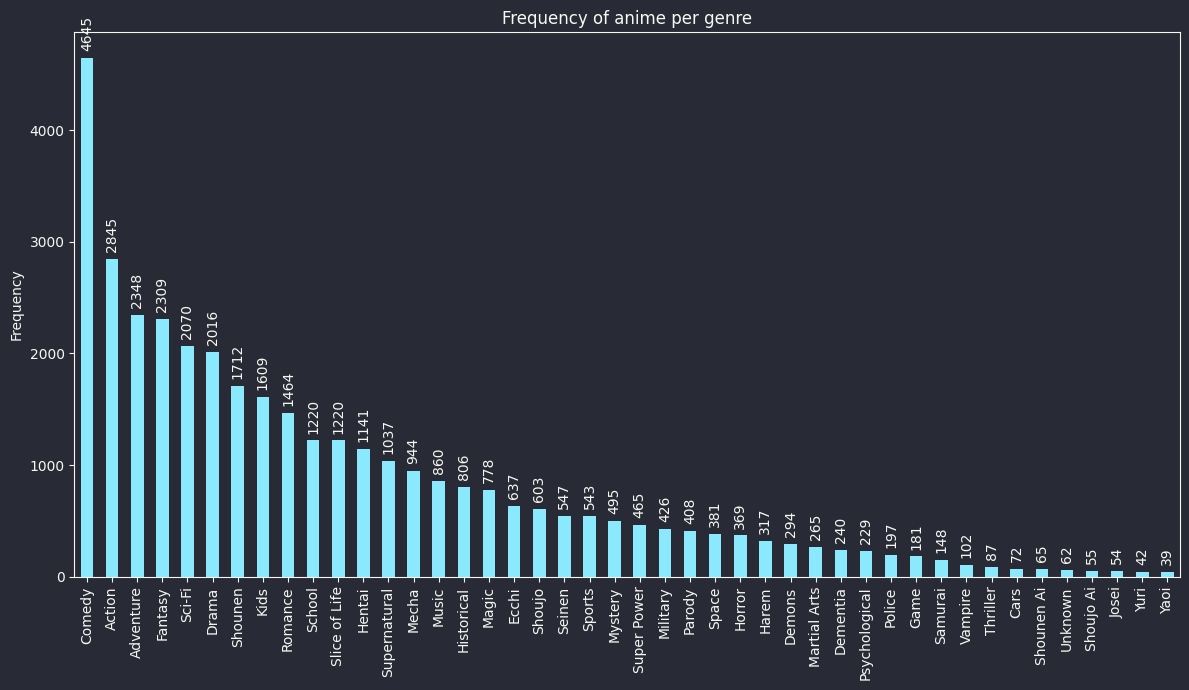

In [55]:
ax = data_anime["genre_split"].explode().value_counts().plot(kind="bar", figsize=FIG_SIZE)
pyplot.title("Frequency of anime per genre")
pyplot.ylabel("Frequency")
ax.bar_label(ax.containers[0], label_type="edge", rotation="vertical", padding=5)
pyplot.tight_layout()
pyplot.show()

**It is clear that here, "comedy" and "action" type anime represent most of the available anime.
One theory at this stage of the analysis would be that these two genres are the "most balanced" in terms of ratings because we will have more data on the ratings of these genres.
However, "Comedy" is quite broad in terms of themes, so having a lot of data is useful on rough interpretations, but requires more in-depth work on more advanced reflections.**

### D.3 - Box plot of rating by genre
In order to obtain a rating by genre for each of the anime, we first divide the genres of each of the anime in the dataset. These genres are then divided into as many new rows as necessary and the anime's rating is added next to the genre of that same anime. In this way, we end up with a new dataset with a list of genres and a note associated with each of them.

In [56]:
genres_rating = data_anime.copy()[["genre_split", "rating"]]
genres_rating = genres_rating.set_index(["rating"]).apply(pandas.Series.explode).reset_index().rename(columns={"genre_split": "genre"})
genres_rating

,rating,genre
0,9.37,Drama
1,9.37,Romance
2,9.37,School
3,9.37,Supernatural
4,9.26,Action
...,...,...
36342,4.15,Hentai
36343,4.28,Hentai
36344,4.88,Hentai
36345,4.98,Hentai


**Now that we have clean data for the ratings, we will be able to choose a graph that can extract the most interesting information from it.
A box plot seems to be the most appropriate since we will be able to obtain quartiles, averages, maximum and minimum values and outliers.**

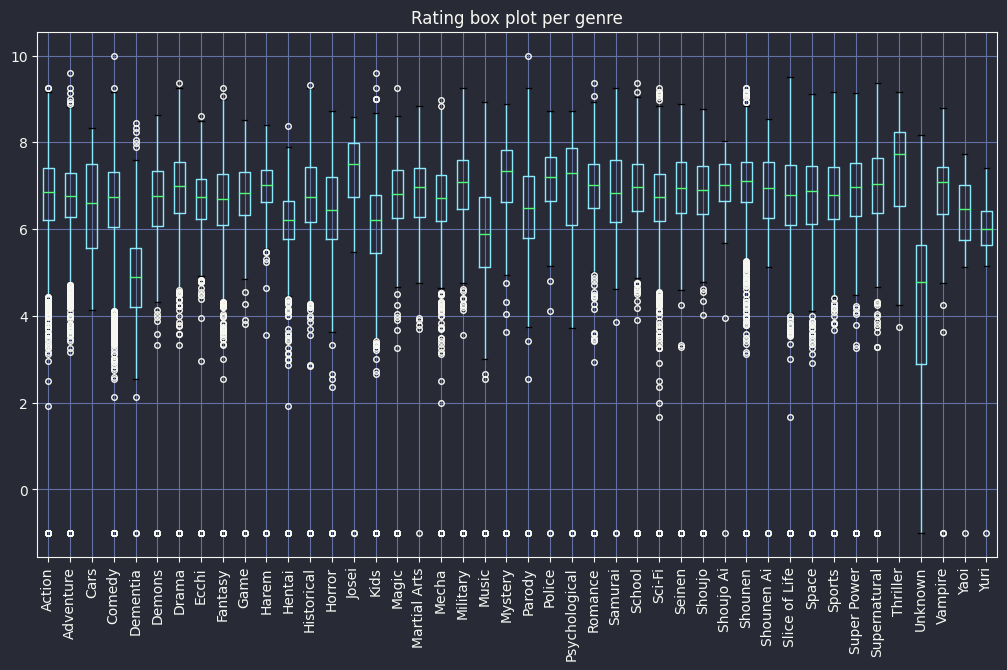

In [57]:
fig, ax = pyplot.subplots(figsize=FIG_SIZE)
genres_rating.boxplot(column=["rating"], by="genre", rot=90, flierprops={"markersize": 4}, ax=ax)
pyplot.title("Rating box plot per genre")
pyplot.suptitle("")
pyplot.xlabel("")
pyplot.show()

**In line with the 50th percentile, the genre with the highest rating is "Slice of Life".
The lowest rating was given to "Dementia".**

**The best average is given to the genre "Thriller" in absolute. However, according to the graph "Distribution by genres", this genre is very little present in the list and seems to agree with our theory.
If we take the most present genres (Comedy, Action, Adventure, Fantasy and Sci-Fi), it seems that the place is disputed between "Action" and "Adventure".**

**Concerning the "outliers", a lot of them concern ratings below the minimum of the genre. These values affect the average and the other values and are therefore to be taken into consideration.
We are not taking "Unknown" into consideration because this kind of data is not precise enough to study on.
Also, there are some outliers at '-1'. These are not a big part of the total number of data we treat, so we consider them as not a big impact.**

### D.4 - Frequency of rating values
**We will now display the frequency of each rating (from 0 to 10).
According to the result, we can easily determine the "global satisfaction" (how are the users satisfied with the content) rating on the catalog.**

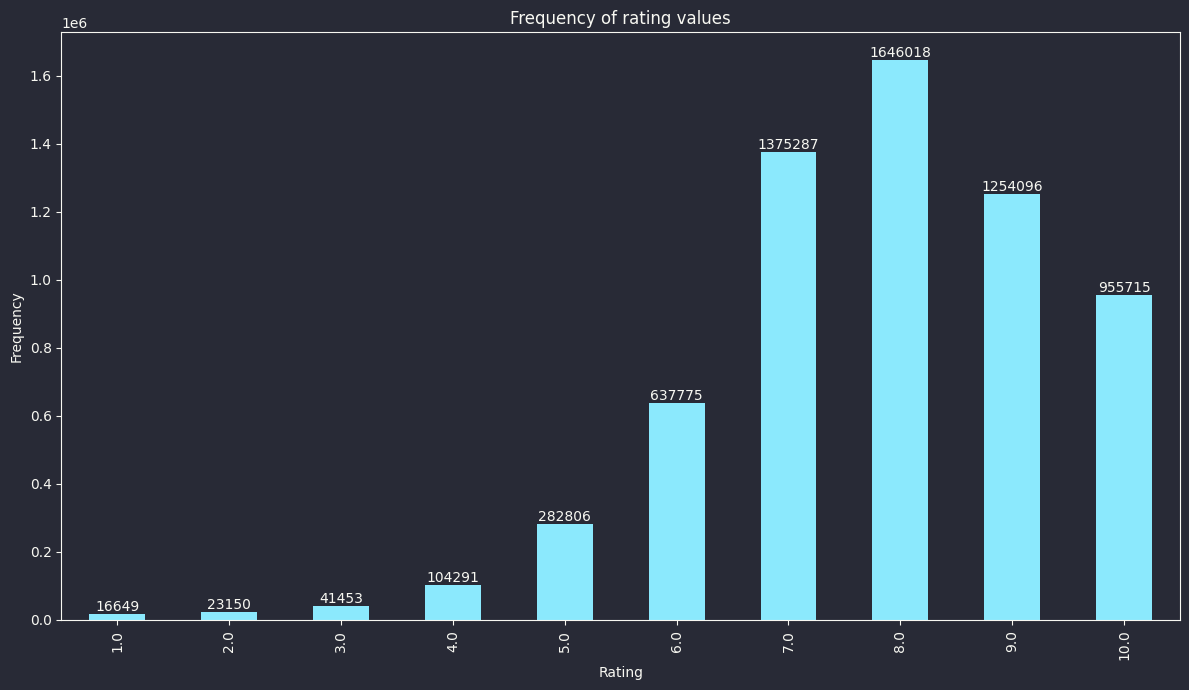

In [58]:
ax = data_ratings[data_ratings["rating"] != -1].groupby(["rating"]).size().plot(kind="bar", figsize=FIG_SIZE)
pyplot.title("Frequency of rating values")
pyplot.xlabel("Rating")
pyplot.ylabel("Frequency")
ax.bar_label(ax.containers[0], label_type="edge", fmt="%.0f")
pyplot.tight_layout()
pyplot.show()

**The majority of the ratings are between 7 and 9, which is a satisfactory "anime quality" indicator.**

### D.5 - Frequency of the number of rating
**Let's look at the number of ratings (by ranges) that come up most often on the anime.**

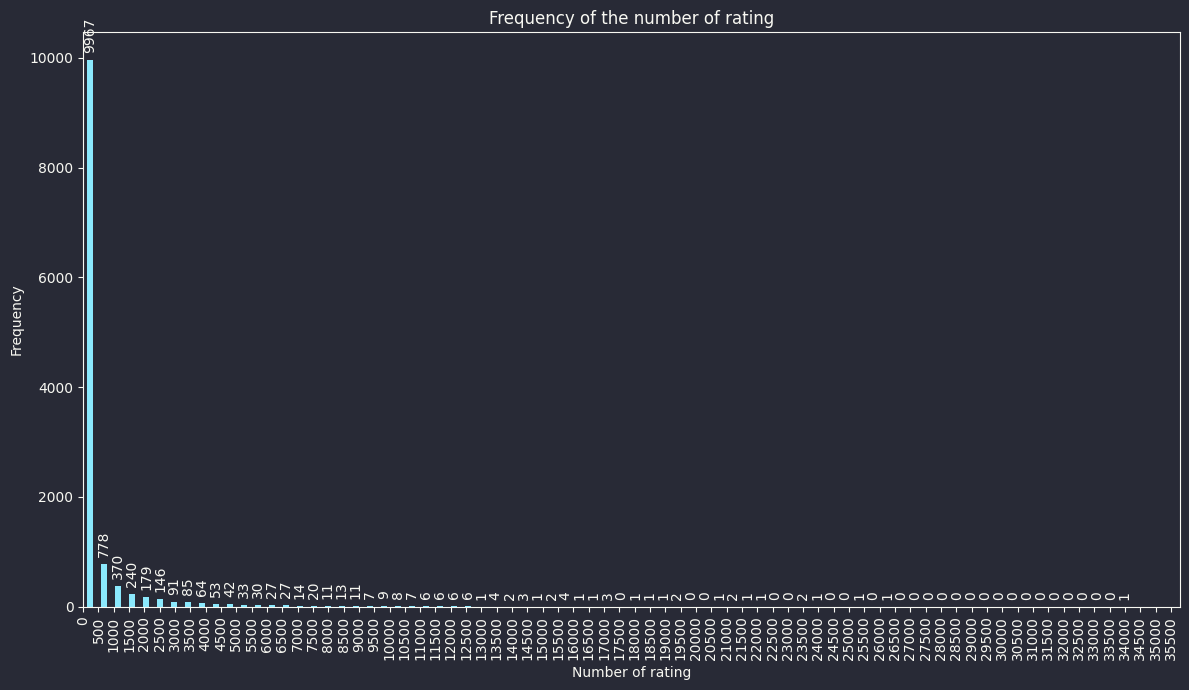

In [59]:
ax = data_anime["num_ratings"].plot(kind="hist", bins=75, figsize=FIG_SIZE, rwidth=0.45)
ax.set_xlim(min(data_anime["num_ratings"]))
min_x, max_x = ax.get_xlim()
ticks = numpy.arange(min_x, max_x, 500)
ax.xaxis.set_ticks(ticks)
ax.set_xticklabels([str(int(t)) for t in ticks], rotation=90)
pyplot.title("Frequency of the number of rating")
pyplot.xlabel("Number of rating")
pyplot.ylabel("Frequency")
ax.bar_label(ax.containers[0], label_type="edge", rotation="vertical", padding=5)
pyplot.tight_layout()
pyplot.show()

**In the vast majority of cases, there are only a very small number of ratings. This does not mean that an anime in question is bad, but it maybe arouses less particular desire to rate it.**

### D.6 - Rating count per genre
**Before proceeding to analyze the rating repartition, we need to manipulate a little more the data we have.
In this case, we'll do some basic calculation to count the number of rating by genres to show them later in graphs.**

In [60]:
ratings_count_per_genre = data_anime.copy()[["genre_split", "num_ratings"]]  # Duplicate the dataset
ratings_count_per_genre = ratings_count_per_genre.set_index(["num_ratings"]).apply(pandas.Series.explode).reset_index()  # Split the "genre" column
ratings_count_per_genre = ratings_count_per_genre.groupby(["genre_split"]).sum()  # Calculate the number of rating per genre
ratings_count_per_genre = ratings_count_per_genre.sort_values(by="num_ratings", ascending=False)  # Sort the dataframe by the number of rating
ratings_count_per_genre

,num_ratings
genre_split,
Comedy,3150030
Action,2663843
Romance,2031673
Drama,1727682
Fantasy,1629075
Supernatural,1612457
School,1540798
Shounen,1514011
Adventure,1365199


**We find here the genres that receive the most rating.
The genres we talked about earlier concerning the box plot come back on top of the list.**

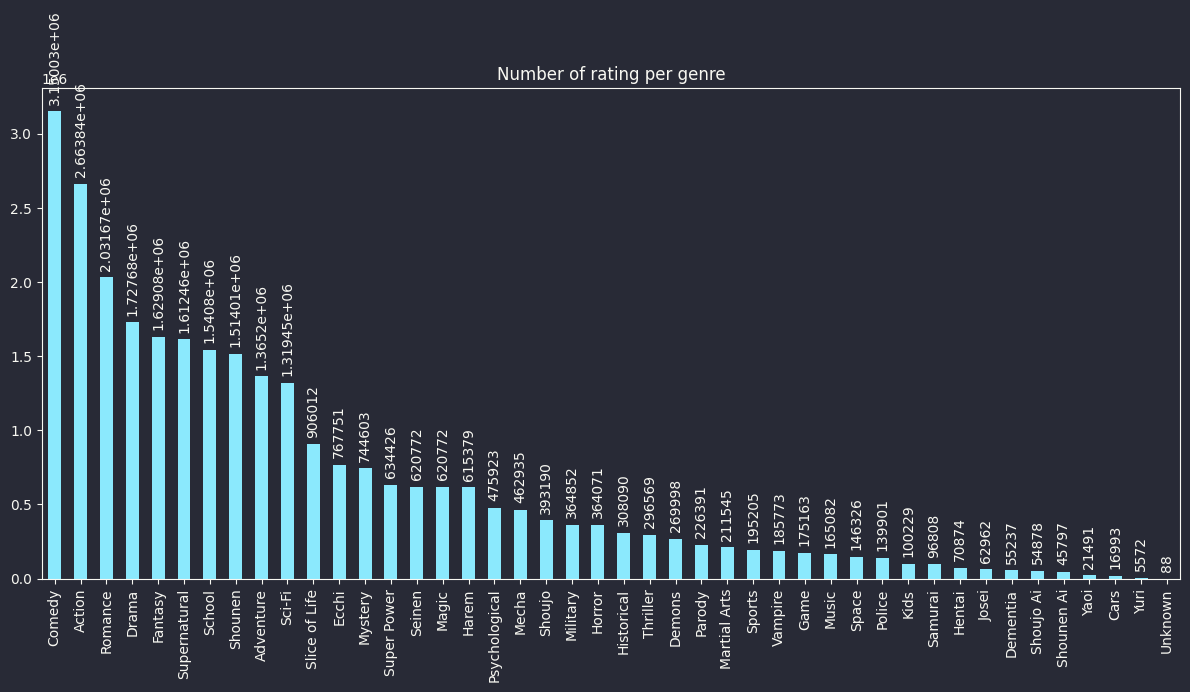

In [61]:
ax = ratings_count_per_genre["num_ratings"].plot(kind="bar", figsize=FIG_SIZE)
pyplot.title("Number of rating per genre")
pyplot.xlabel("")
ax.bar_label(ax.containers[0], label_type="edge", rotation="vertical", padding=5)
pyplot.tight_layout()
pyplot.show()

**This graph confirms some of what was said earlier about the box plot.
For example, we have "Yuri" which has the lowest number of rating.**

### D.7 - Ranking by average rating

In [62]:
data_anime.sort_values(by="rank_avg_rating", ascending=True).head(n=10)

,anime_id,name,genre,genre_split,type,episodes,rating,members,num_ratings,rank_avg_rating,rank_num_ratings
10464,33662,Taka no Tsume 8: Yoshida-kun no X-Files,"Comedy, Parody","[Comedy, Parody]",Movie,1,10.00,13,0,1.0,11110.5
10400,30120,Spoon-hime no Swing Kitchen,"Adventure, Kids","[Adventure, Kids]",TV,-1,9.60,47,0,2.0,11110.5
9595,23005,Mogura no Motoro,Slice of Life,[Slice of Life],Movie,1,9.50,62,0,3.0,11110.5
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural","[Drama, Romance, School, Supernatural]",Movie,1,9.37,200630,1961,4.0,870.5
9078,33607,Kahei no Umi,Historical,[Historical],Movie,1,9.33,44,0,5.0,11110.5
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...","[Action, Adventure, Drama, Fantasy, Magic, Mil...",TV,64,9.26,793665,21494,6.0,8.0
10786,26313,Yakusoku: Africa Mizu to Midori,"Drama, Kids","[Drama, Kids]",OVA,1,9.25,53,0,7.5,11110.5
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...","[Action, Comedy, Historical, Parody, Samurai, ...",TV,51,9.25,114262,1188,7.5,1313.5
3,9253,Steins;Gate,"Sci-Fi, Thriller","[Sci-Fi, Thriller]",TV,24,9.17,673572,17151,9.0,17.0
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...","[Action, Comedy, Historical, Parody, Samurai, ...",TV,51,9.16,151266,3115,10.0,537.0


**The previous table represents the ranking of the best average rated anime.
However, the ranking should be taken with care because the number of rating on the anime of the podium have a huge impact on the place.
The number 1 of the list, which has the best average of 10, have a "num_rating" of 0.**

### D.8 - Ranking by number of rating
**The next table represents the ranking of the most active anime in terms of ratings.
It confirms again the impact observed by the most popular genres of the catalog with notably the podium composed of the genres "Action" or "Drama" with the anime "Death Note".**

In [63]:
data_anime.sort_values(by="rank_num_ratings", ascending=True).head(n=10)

,anime_id,name,genre,genre_split,type,episodes,rating,members,num_ratings,rank_avg_rating,rank_num_ratings
40,1535,Death Note,"Mystery, Police, Psychological, Supernatural, ...","[Mystery, Police, Psychological, Supernatural,...",TV,37,8.71,1013917,34226,53.5,1.0
804,11757,Sword Art Online,"Action, Adventure, Fantasy, Game, Romance","[Action, Adventure, Fantasy, Game, Romance]",TV,25,7.83,893100,26310,900.5,2.0
86,16498,Shingeki no Kyojin,"Action, Drama, Fantasy, Shounen, Super Power","[Action, Drama, Fantasy, Shounen, Super Power]",TV,25,8.54,896229,25289,106.0,3.0
19,1575,Code Geass: Hangyaku no Lelouch,"Action, Mecha, Military, School, Sci-Fi, Super...","[Action, Mecha, Military, School, Sci-Fi, Supe...",TV,25,8.83,715151,24126,32.0,4.0
159,6547,Angel Beats!,"Action, Comedy, Drama, School, Supernatural","[Action, Comedy, Drama, School, Supernatural]",TV,13,8.39,717796,23565,198.5,5.0
760,226,Elfen Lied,"Action, Drama, Horror, Psychological, Romance,...","[Action, Drama, Horror, Psychological, Romance...",TV,13,7.85,623511,23528,865.5,6.0
841,20,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...","[Action, Comedy, Martial Arts, Shounen, Super ...",TV,220,7.81,683297,22071,938.0,7.0
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...","[Action, Adventure, Drama, Fantasy, Magic, Mil...",TV,64,9.26,793665,21494,6.0,8.0
200,121,Fullmetal Alchemist,"Action, Adventure, Comedy, Drama, Fantasy, Mag...","[Action, Adventure, Comedy, Drama, Fantasy, Ma...",TV,51,8.33,600384,21332,244.5,9.0
13,2904,Code Geass: Hangyaku no Lelouch R2,"Action, Drama, Mecha, Military, Sci-Fi, Super ...","[Action, Drama, Mecha, Military, Sci-Fi, Super...",TV,25,8.98,572888,21124,25.0,10.0


## E - Conclusion of the data analysis
The analysis of the datasets allows us to observe several things. The data is nearly complete and contain only one duplicate.
However, some data is missing in one of the datasets.

After some calculations and column addition, the graphs showed us very interesting results such as outliers or some unbalanced but clean data between columns and rows.

In the next notebook, we will discuss the collaborative filtering to train our models with the formatted data accomplished in this notebook.